In [1]:
import os
import sys
os.environ["UW_ENABLE_TIMING"] = "1"
import underworld as uw
from underworld import function as fn
from underworld.scaling import units as u
from underworld.scaling import dimensionalise as dm, non_dimensionalise as nd
import glucifer
import numpy as np

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: mpi4py.MPI.Win size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  return f(*args, **kwds)


In [2]:
#
# Scaling and Units
#
# Dimentional Parameters
modelHeight = 2891 * u.kilometer
earthRadius = 6371 * u.kilometer
modelCartAspect=4
ThetaRAD=np.rad2deg((modelHeight*modelCartAspect)/earthRadius)

# plateHeight = 120. * u.kilometer
refDensity = 3200.0 * u.kilogram / u.meter ** 3
deltaRhoMax = 80.0 * u.kilogram / u.meter ** 3
gravity = 9.8 * u.metre / u.second ** 2
# 1.57e20 * u.pascal * u.second 5.e20 * u.pascal * u.second
refViscosity = 5.0e20 * u.pascal * u.second
bodyForce = deltaRhoMax * gravity

# scaling coefficients
K_eta = refViscosity
KL = modelHeight
K_tau = bodyForce * modelHeight
K_v = K_tau * modelHeight / K_eta
# Kt = KL/K_v
Kt = K_eta / K_tau
KM = K_tau * modelHeight * Kt ** 2

scaling_coefficients = uw.scaling.get_coefficients()

scaling_coefficients["[length]"] = KL.to_base_units()
# scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[time]"] = Kt.to_base_units()
scaling_coefficients["[mass]"] = KM.to_base_units()

In [29]:
mesh = uw.mesh.FeMesh_Annulus(
        elementRes = (128,128),
        radialLengths = (nd(earthRadius-modelHeight),nd(earthRadius)),
        angularExtent=((180-ThetaRAD.magnitude)/2,90+ThetaRAD.magnitude/2)
)
        

velocityField       = mesh.add_variable( nodeDofCount=2 )
pressureField       = mesh.subMesh.add_variable( nodeDofCount=1 )

swarm = uw.swarm.Swarm(mesh, particleEscape=True)
materialVariable=swarm.add_variable(count=1,dataType="int")
layout = uw.swarm.layouts.PerCellSpaceFillerLayout(swarm, particlesPerCell=10)
swarm.populate_using_layout(layout)
advector = uw.systems.SwarmAdvector(velocityField=velocityField, swarm=swarm)

In [30]:
lower = mesh.specialSets["Bottom_VertexSet"]
upper = mesh.specialSets["Top_VertexSet"]
left  = mesh.specialSets["Left_VertexSet"]
right = mesh.specialSets["Right_VertexSet"]
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
# iWalls+jWalls-lower-upper-left-right

In [31]:
velocityField.data[:]=[0.,0.]       
freeslipBC = uw.conditions.RotatedDirichletCondition(variable=velocityField,
                                                   indexSetsPerDof=(iWalls, jWalls),
                                                   basis_vectors = (mesh.bnd_vec_normal, 
                                                                    mesh.bnd_vec_tangent)
                                                  )


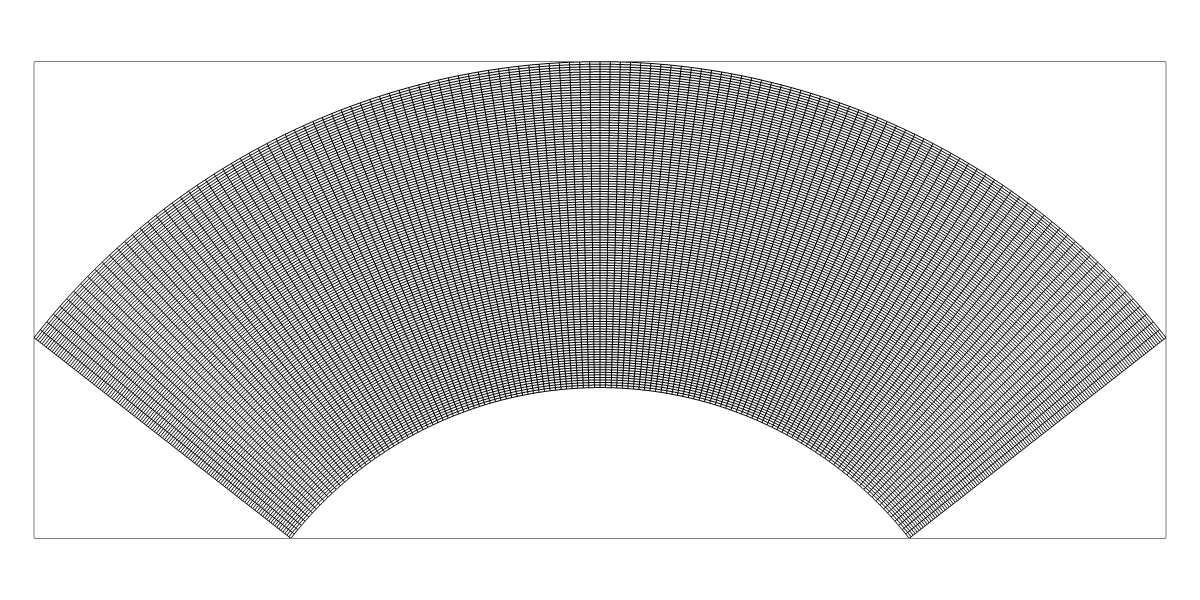

In [32]:
store=None
fig = glucifer.Figure(store=store,figsize=(1200,600))
# fig.append( glucifer.objects.Mesh( mesh ,nodeNumbers=True))
fig.append( glucifer.objects.Mesh( mesh ))
# fig.append( glucifer.objects.Points( swarm,pointsize=4))
fig.show()

In [33]:
figV=glucifer.Figure(store=store,figsize=(1200,600))
figV.Surface(mesh,fn.math.dot(velocityField,velocityField),colours='spectral')
# figV.show()

In [34]:
radialFn = fn.math.sqrt(fn.math.dot(fn.coord(), fn.coord()))
thetaFn = fn.math.atan2(fn.coord()[1], fn.coord()[0])

In [35]:
# def make_slab(startTheta,length,)

In [10]:

# for index,coord in enumerate(swarm.data):
#     r,theta=cart2pol(coord[0],coord[1])
#     if r>nd(earthRadius-660.*u.kilometer):
#         materialVariable.data[index]=1
materialVariable.data[:]=1
materialVariable.data[radialFn.evaluate(swarm.data)>nd(earthRadius-660.*u.kilometer)]=0
sarc=(modelHeight*1.5/earthRadius).magnitude
slab=(thetaFn.evaluate(swarm.data)>np.radians(90)) & \
     (thetaFn.evaluate(swarm.data)<np.radians(90)+sarc) & \
     (radialFn.evaluate(swarm.data)>nd(earthRadius-80.*u.kilometer)) 
perturb=(thetaFn.evaluate(swarm.data)>np.radians(90)) & \
    (thetaFn.evaluate(swarm.data)<np.radians(91)) & \
    (radialFn.evaluate(swarm.data)>nd(earthRadius-170.*u.kilometer)) 
# materialVariable.data[perturb]=3
materialVariable.data[slab | perturb]=2


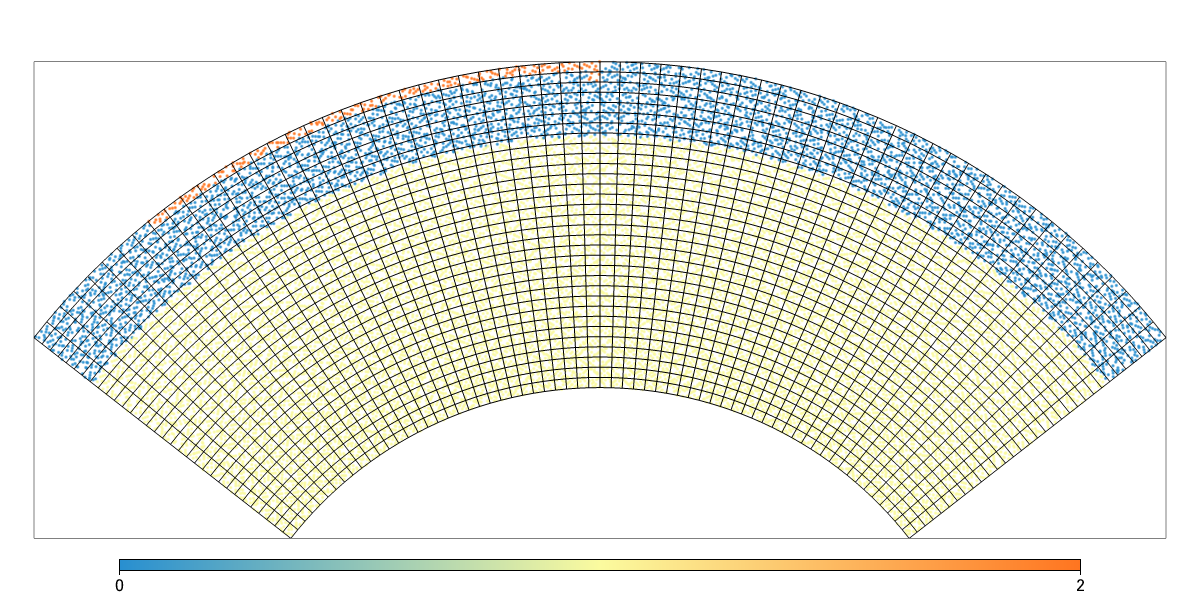

In [11]:
store=None
fig = glucifer.Figure(store=store,figsize=(1200,600))
fig.append( glucifer.objects.Mesh( mesh))
fig.append( glucifer.objects.Points( swarm,materialVariable,pointsize=4))

fig.show()

In [12]:
# strainRate_2ndInvariant = fn.tensor.second_invariant( 
#                             fn.tensor.symmetric( 
#                             velocityField.fn_gradient ))
# cohesion = 0.06
# vonMises = 0.5 * cohesion / (strainRate_2ndInvariant+1.0e-18)

# slabYieldvisc = fn.exception.SafeMaths( fn.misc.min(vonMises, slabViscosity) )
viscosityMap = {0 : 1., 
                1 : 100., 
                2 : 1000.,
               }
viscosityFn = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )



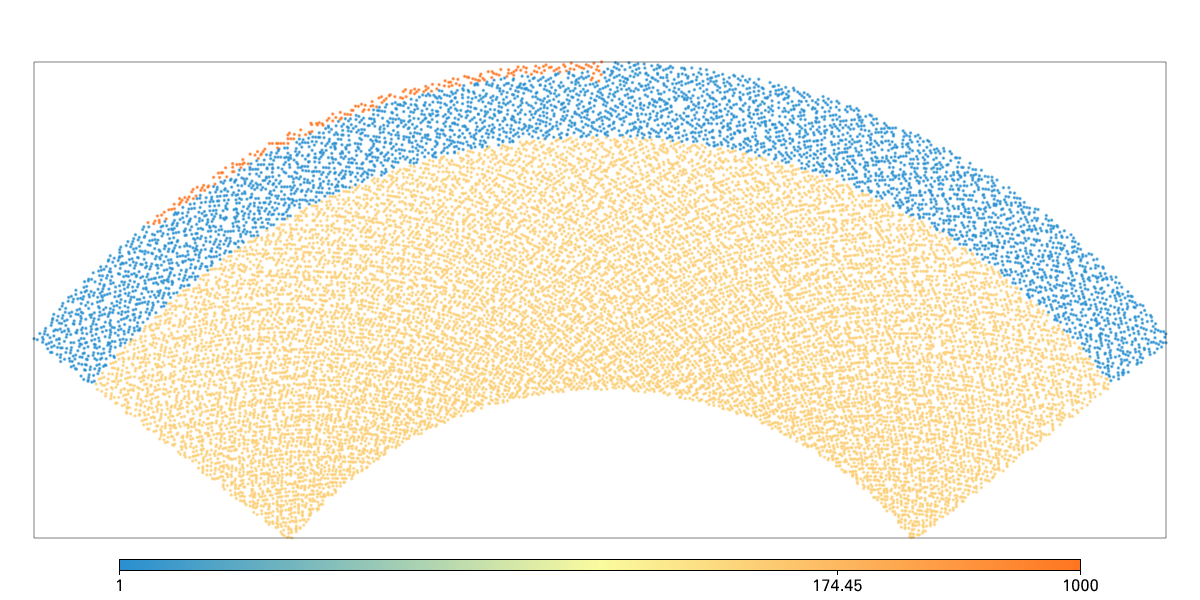

In [13]:
store=None
figVisc = glucifer.Figure(store=store,figsize=(1200,600))
figVisc.append( glucifer.objects.Points( swarm,viscosityFn,pointsize=4,logScale=True))

figVisc.show()

In [14]:
densityMap = {0 : 0.0, 
              1 : 0.5, 
              2 : 1.0,
             }
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

bodyForceFn =-1.* densityFn  * mesh.unitvec_r_Fn
# bodyForceProj=


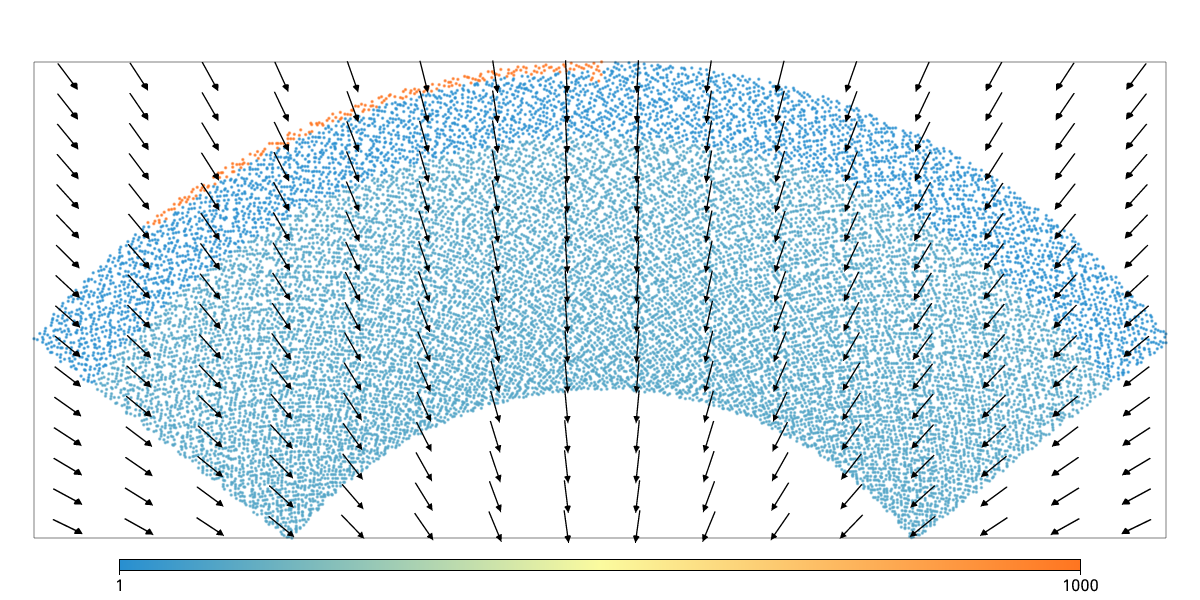

In [17]:
figDensity = glucifer.Figure(store=store,figsize=(1200,600))
figDensity.append( glucifer.objects.Points( swarm,viscosityFn,pointsize=4))
figDensity.append(glucifer.objects.VectorArrows( mesh,-1.*mesh.unitvec_r_Fn))
figDensity.show()

In [18]:
 = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = freeslipBC,
                            fn_viscosity  = viscosityFn, 
                            fn_bodyforce  = bodyForceFn,
                            _removeBCs    = False)      # _removeBC is required


In [20]:

stokesSolverAN = uw.systems.Solver(stokesSLE)

stokesSolverAN.options.A11.ksp_type="fgmres"
stokesSolverAN.options.scr.ksp_rtol=1.0e-4
stokesSolverAN.options.scr.ksp_max_it=100
stokesSolverAN.options.scr.ksp_monitor="ascii"
stokesSolverAN.options.scr.ksp_type="fgmres"
stokesSolverAN.options.A11.ksp_rtol=1.0e-5
stokesSolverAN.options.A11.ksp_monitor="ascii"

stokesSolverAN.set_penalty(10.0)
stokesSolverAN.options.main.restore_K=True
stokesSolverAN.options.main.force_correction=True
stokesSolverAN.options.main.Q22_pc_type="gkgdiag"

stokesSolverAN.options.mg_accel.mg_accelerating_smoothing=True
stokesSolverAN.options.mg_accel.mg_smooths_to_start=3
stokesSolverAN.options.mg_accel.mg_smooths_max=10
stokesSolverAN.options.mg.mg_levels_ksp_convergence_test='skip'
stokesSolverAN.options.mg.mg_levels_ksp_norm_type='none'
stokesSolverAN.options.mg.mg_levels_ksp_max_it=5
stokesSolverAN.options.mg.mg_levels_ksp_type="chebyshev"
stokesSolverAN.options.mg.mg_coarse_pc_type="lu"
stokesSolverAN.options.mg.mg_coarse_pc_factor_mat_solver_package="mumps"

In [22]:
time = 0.
step = 0
maxtimeSteps=100

In [23]:
advector = uw.systems.SwarmAdvector(velocityField=velocityField, swarm=swarm)


In [24]:
while step < maxtimeSteps:
    stokesSolverAN.solve(print_stats=True, reinitialise=True)
    uw.libUnderworld.Underworld.AXequalsX( stokesSLE._rot._cself, stokesSLE._velocitySol._cself, False)
    dt=advector.get_max_dt()
    advector.integrate(dt)
    step=step+1
    time=time+dt
    if(step%2==0)
    figV.show()
    figVisc.show()


Setup - BCs        2.098e-05 s
Setup - Eq numbers 8.798e-05 s
Setup - Zero vecs  2.813e-05 s
Setup - Matrices   0.3384 s
Setup - Vectors    0.1341 s

 
Pressure iterations:  20
Velocity iterations:  13 (presolve)      
Velocity iterations: 240 (pressure solve)
Velocity iterations:  12 (backsolve)     
Velocity iterations: 265 (total solve)   
 
SCR RHS  setup time: 5.1370e-03
SCR RHS  solve time: 2.6040e-02
Pressure setup time: 3.5620e-04
Pressure solve time: 3.4675e-01
Velocity setup time: 1.3130e-03 (backsolve)
Velocity solve time: 2.2636e-02 (backsolve)
Total solve time   : 4.1612e-01
 



In [ ]:
# figV.Surface(mesh,fn.math.dot(velocityField,velocityField),colours='spectral')
figV.show()


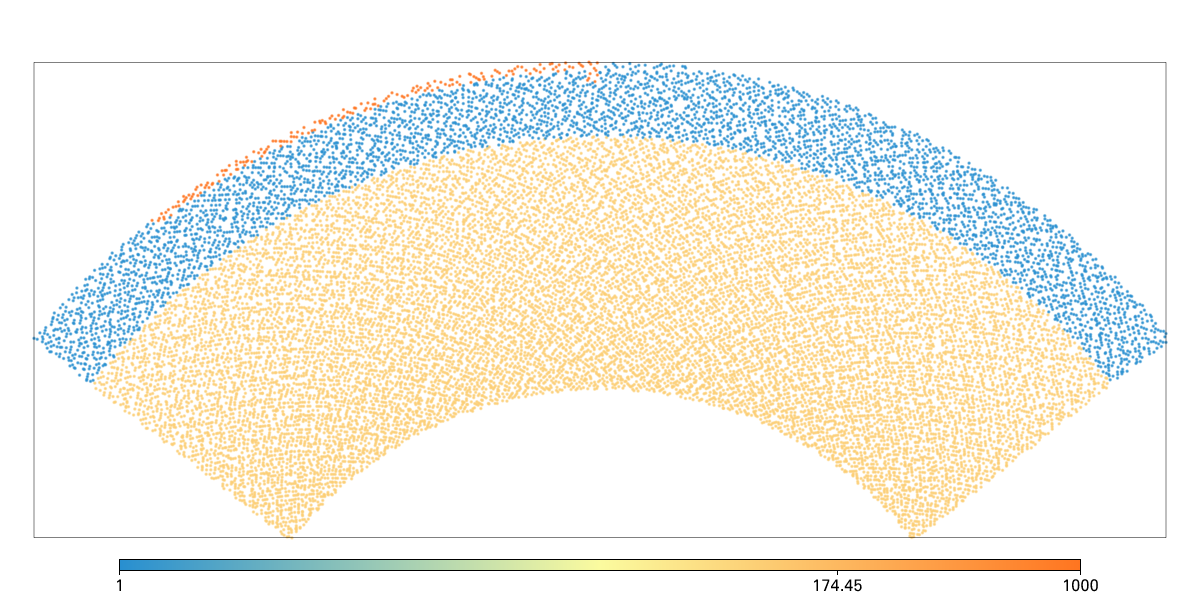

In [95]:
figVisc.show()